In [1]:
!pip install aeon --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 2.0.3 which is incompatible.


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error

from aeon.datasets import load_classification, load_regression

import time
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
N_EXP    = 1
N_EPOCHS = 1000
PATIENCE = 20
LR       = 0.001 # Leaning rate

device = torch.device('cuda')
print('-----> ', device)

----->  cuda


# Implementação da FCN

Paper: https://arxiv.org/pdf/1611.06455

In [ ]:
class FCN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.layers = nn.ModuleList([
            # First convolutional layer.
            nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=8, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            # Second convolutional layer.
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            # Third convolutional layer.
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            # Global Average Pooling and Flattening.
            nn.AdaptiveAvgPool1d(output_size=1),
            nn.Flatten()
        ])

    def forward(self, x):
        # Processing every layer in the FCN and then returning.
        for layer in self.layers:
            x = layer(x)

        return x

class FCNClassifier(FCN):

    def __init__(self, input_channels, num_classes):
        super().__init__(input_channels)
        self.final_layer = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = super().forward(x)
        x = self.final_layer(x)

        return x

class FCNRegressor(FCN):

    def __init__(self, input_channels):
        super().__init__(input_channels)
        self.final_layer = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        x = super().forward(x)
        x = self.final_layer(x)

        return x

# Treinamento

## Classificação

In [4]:
# Training the classification model.
def train_cls(model, train_loader, val_loader, criterion, optimizer, save_path, single_result):
    # Inicializing the best validation loss to do a early stopping.
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(N_EPOCHS):
        # Training loop.
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU.

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop.
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU.

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Verifying a possible early stopping.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                torch.load(save_path, weights_only=True)
                break

        # Storing the losses to put it later in a JSON file.
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        single_result['train_losses'] = train_losses
        single_result['val_losses'] = val_losses

        print(f"Epoch {epoch+1}/{N_EPOCHS}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

# Evaluating the classification model.
def evaluate_cls(model, test_loader, single_result):
    model.eval()

    y_true = []
    y_pred = []

    # Evaluation loop.
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU.

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Storing the metrics and labels to put it later in a JSON file.
    single_result['acc'] = accuracy_score(y_true, y_pred)
    single_result['f1_macro'] = f1_score(y_true, y_pred, average='macro')
    single_result['f1_micro'] = f1_score(y_true, y_pred, average='micro')
    single_result['y_true'] = [int(x) for x in y_true]
    single_result['y_pred'] = [int(x) for x in y_pred]

In [ ]:
# Loading the dataset.
dataset_cls = 'ArrowHead'
X_train, y_train = load_classification(dataset_cls, split="train")
X_test, y_test = load_classification(dataset_cls, split="test")

# Changing the labels (strings) to intengers.
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Converting the data to PyTorch tensors.
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).long().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).long().to(device)

# Dividing train data into train and validation parts.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Creating DataLoader to load the data in batches.
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Storing some data (metrics, losses and labels) to put it later into a JSON file.
results = []
for i in range(N_EXP):
    results.append({})

for i in range(N_EXP):
    start_time = time.time()

    # Defining the model, loss function and optimizer.
    model = FCNClassifier(input_channels=X_train.shape[1], num_classes=len(torch.unique(y_train))).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Changing the path where the data will be saved.
    save_path = './cls/'
    file_name = 'best_model_' + str(i+1) + '.pth'

    # Training and evaluating the model.
    train_cls(model, train_loader, val_loader, criterion, optimizer, save_path+file_name, results[i])
    evaluate_cls(model, test_loader, results[i])

    # Preparing the training time to store it later.
    end_time = time.time()
    time_spent = np.round(end_time-start_time, 2)
    results[i]['time'] = time_spent

    # Printing some useful data.
    print(' Dataset: ', dataset_cls, '(', i+1, ')')
    print('Acurácia: ', results[i]['acc'])
    print('F1 Macro: ', results[i]['f1_macro'])
    print('F1 Micro: ', results[i]['f1_micro'])
    print('    Time: ', results[i]['time'], 'seconds')
    print('----------------------------------')

# Storing all the data needed.
with open(save_path+'data.json', 'w') as f:
    json.dump(results, f)

Epoch 1/1000, Train Loss: 1.116167664527893, Val Loss: 1.0998735427856445
Epoch 2/1000, Train Loss: 1.0302189588546753, Val Loss: 1.1021580696105957
Epoch 3/1000, Train Loss: 0.9858325123786926, Val Loss: 1.1033191680908203
Epoch 4/1000, Train Loss: 0.9557704925537109, Val Loss: 1.1062211990356445
Epoch 5/1000, Train Loss: 0.9283960461616516, Val Loss: 1.107940673828125
Epoch 6/1000, Train Loss: 0.9034737348556519, Val Loss: 1.1063342094421387
Epoch 7/1000, Train Loss: 0.8809158205986023, Val Loss: 1.1063803434371948
Epoch 8/1000, Train Loss: 0.8576908707618713, Val Loss: 1.1059014797210693
Epoch 9/1000, Train Loss: 0.8381022810935974, Val Loss: 1.0999232530593872
Epoch 10/1000, Train Loss: 0.8207241296768188, Val Loss: 1.103821039199829
Epoch 11/1000, Train Loss: 0.7993603348731995, Val Loss: 1.104220986366272
Epoch 12/1000, Train Loss: 0.7841538786888123, Val Loss: 1.0941156148910522
Epoch 13/1000, Train Loss: 0.7682803273200989, Val Loss: 1.0891518592834473
Epoch 14/1000, Train Loss

## Regressão Extrínseca

In [5]:
# Training the extrinsic regression model.
def train_tser(model, train_loader, val_loader, criterion, optimizer, save_path, single_result):
    # Inicializing the best validation loss to do a early stopping.
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(N_EPOCHS):
        # Training loop.
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Moving data to GPU.

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop.
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Moving data to GPU.

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Verifying a possible early stopping.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                torch.load(save_path, weights_only=True)
                break

        # Storing the losses to put it later in a JSON file.
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        single_result['train_losses'] = train_losses
        single_result['val_losses'] = val_losses

        print(f"Epoch {epoch+1}/{N_EPOCHS}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

# Evaluating the extrinsic regression model.
def evaluate_tser(model, test_loader, single_result):
    model.eval()

    y_true = []
    y_pred = []

    # Evaluation loop.
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Moving data to GPU.

            outputs = model(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    # Storing the metrics to put it later in a JSON file.
    single_result['mse'] = mse = float(mean_squared_error(y_true, y_pred))
    single_result['rmse'] = np.sqrt(mse)
    single_result['mae'] = float(mean_absolute_error(y_true, y_pred))

In [ ]:
# Loading the dataset.
dataset_tser = 'Covid3Month'
X_train, y_train = load_regression(dataset_tser, split="train")
X_test, y_test = load_regression(dataset_tser, split="test")

# Converting the data to PyTorch tensors.
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().unsqueeze(1).to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().unsqueeze(1).to(device)

# Dividing train data into train and validation parts.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Creating DataLoader to load the data in batches.
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Storing some data (metrics, losses and targets) to put it later into a JSON file.
results = []
for i in range(N_EXP):
    results.append({})

for i in range(N_EXP):
    start_time = time.time()

    # Defining the model, loss function and optimizer.
    model = FCNRegressor(X_train.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Changing the path where the data will be saved.
    save_path = './tser/'
    file_name = 'best_model_' + str(i+1) + '.pth'

    # Training and evaluating the model.
    train_tser(model, train_loader, val_loader, criterion, optimizer, save_path+file_name, results[i])
    evaluate_tser(model, test_loader, results[i])

    # Preparing the training time to store it later.
    end_time = time.time()
    time_spent = np.round(end_time-start_time, 2)
    results[i]['time'] = time_spent

    # Printing some useful data.
    print('Dataset: ', dataset_tser, '(', i+1, ')')
    print('    MAE: ', results[i]['mae'])
    print('    MSE: ', results[i]['mse'])
    print('   RMSE: ', results[i]['rmse'])
    print('   Time: ', results[i]['time'], 'seconds')
    print('----------------------------------')

# Storing all the data needed.
with open(save_path+'data.json', 'w') as f:
    json.dump(results, f)

Epoch 1/1000, Train Loss: 0.304879785515368, Val Loss: 0.3724372982978821
Epoch 2/1000, Train Loss: 0.10450329910963774, Val Loss: 0.11157334595918655
Epoch 3/1000, Train Loss: 0.05213301442563534, Val Loss: 0.30898594856262207
Epoch 4/1000, Train Loss: 0.025295259431004524, Val Loss: 0.18977662920951843
Epoch 5/1000, Train Loss: 0.006518955575302243, Val Loss: 0.03490106016397476
Epoch 6/1000, Train Loss: 0.0018888142658397555, Val Loss: 0.0037765339948236942
Epoch 7/1000, Train Loss: 0.003201904008165002, Val Loss: 0.02682996727526188
Epoch 8/1000, Train Loss: 0.003193213138729334, Val Loss: 0.03169327601790428
Epoch 9/1000, Train Loss: 0.001744117063935846, Val Loss: 0.012418647296726704
Epoch 10/1000, Train Loss: 0.0016094757011160254, Val Loss: 0.0036979850847274065
Epoch 11/1000, Train Loss: 0.0017317289020866156, Val Loss: 0.002691645873710513
Epoch 12/1000, Train Loss: 0.0017729924875311553, Val Loss: 0.0026093150954693556
Epoch 13/1000, Train Loss: 0.00160346704069525, Val Los

# Resultados

## Funções úteis

In [6]:
def load_results(path):
    with open(path, 'r') as f:
        results = json.load(f)

    return results

def get_cls_metrics(results):
    list_acc = []
    list_f1_macro = []
    list_f1_micro = []
    list_time = []

    for i in range(N_EXP):
        list_acc.append(results[i]['acc'])
        list_f1_macro.append(results[i]['f1_macro'])
        list_f1_micro.append(results[i]['f1_micro'])
        list_time.append(results[i]['time'])

    metrics = {}
    metrics['mean_acc']  = np.mean(list_acc)
    metrics['std_acc'] = np.std(list_acc)
    metrics['mean_f1_macro'] = np.mean(list_f1_macro)
    metrics['std_f1_macro'] = np.std(list_f1_macro)
    metrics['mean_f1_micro'] = np.mean(list_f1_micro)
    metrics['std_f1_micro'] = np.std(list_f1_micro)
    metrics['mean_time'] = np.mean(list_time)
    metrics['std_time'] = np.std(list_time)

    return metrics

def get_tser_metrics(results):
    list_mse = []
    list_rmse = []
    list_mae = []
    list_time = []

    for i in range(N_EXP):
        list_mse.append(results[i]['mse'])
        list_rmse.append(results[i]['rmse'])
        list_mae.append(results[i]['mae'])
        list_time.append(results[i]['time'])

    metrics = {}
    metrics['mean_mse']  = np.mean(list_mse)
    metrics['std_mse'] = np.std(list_mse)
    metrics['mean_rmse'] = np.mean(list_rmse)
    metrics['std_rmse'] = np.std(list_rmse)
    metrics['mean_mae'] = np.mean(list_mae)
    metrics['std_mae'] = np.std(list_mae)
    metrics['mean_time'] = np.mean(list_time)
    metrics['std_time'] = np.std(list_time)

    return metrics

def plot_loss_graph(results, i):
    y1 = results[i]['train_losses'][10:]
    y2 = results[i]['val_losses'][10:]

    plt.plot(np.arange(10,len(y1)+10), y1, label='Train Loss')
    plt.plot(np.arange(10,len(y1)+10), y2, label='Validation Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(results, i):
    y_pred = results[i]['y_pred']
    y_true = results[i]['y_true']

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Classificação

  Acurácia:  0.49 +- 0.12
  F1 Macro:  0.45 +- 0.14
  F1 Micro:  0.49 +- 0.12
Time (sec):  1.0 +- 0.62


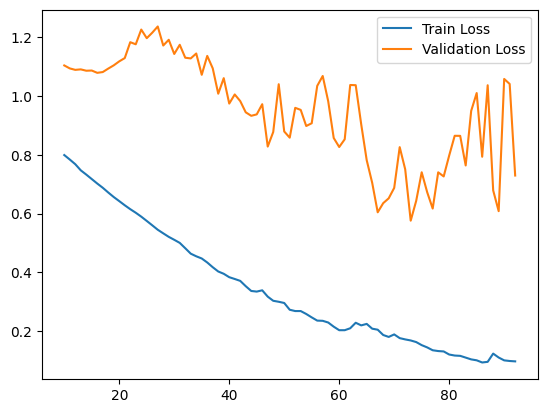

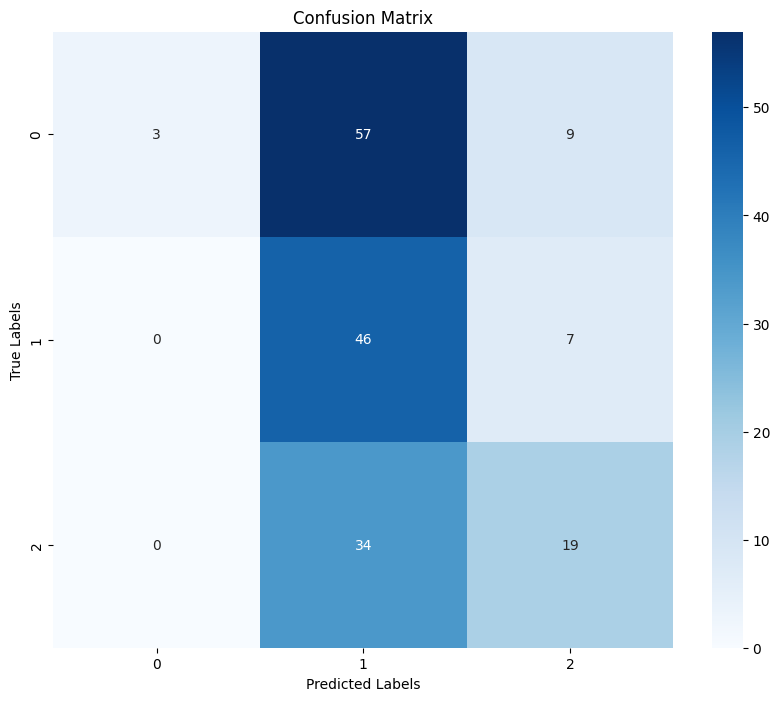

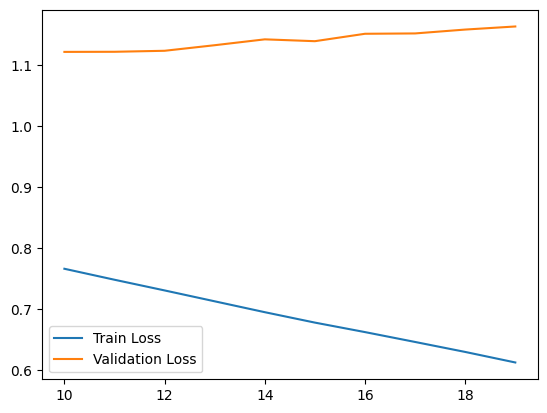

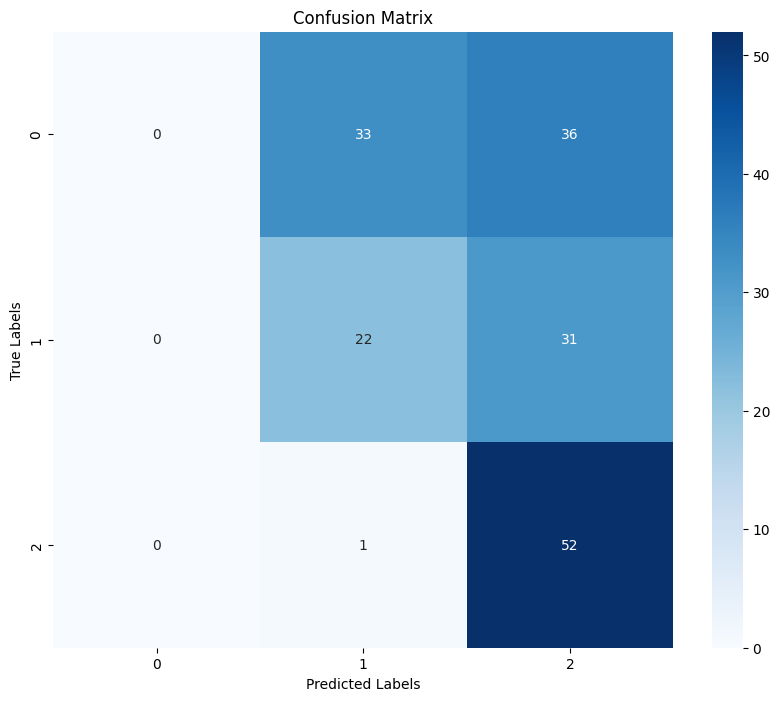

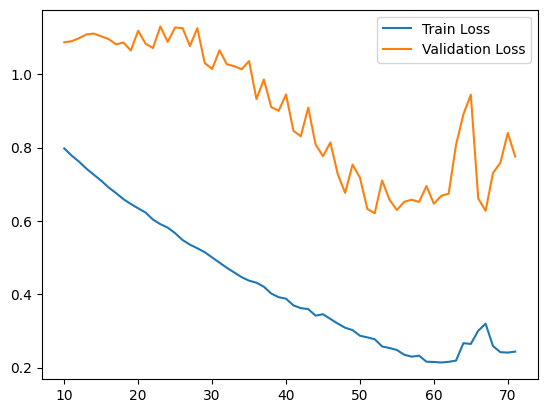

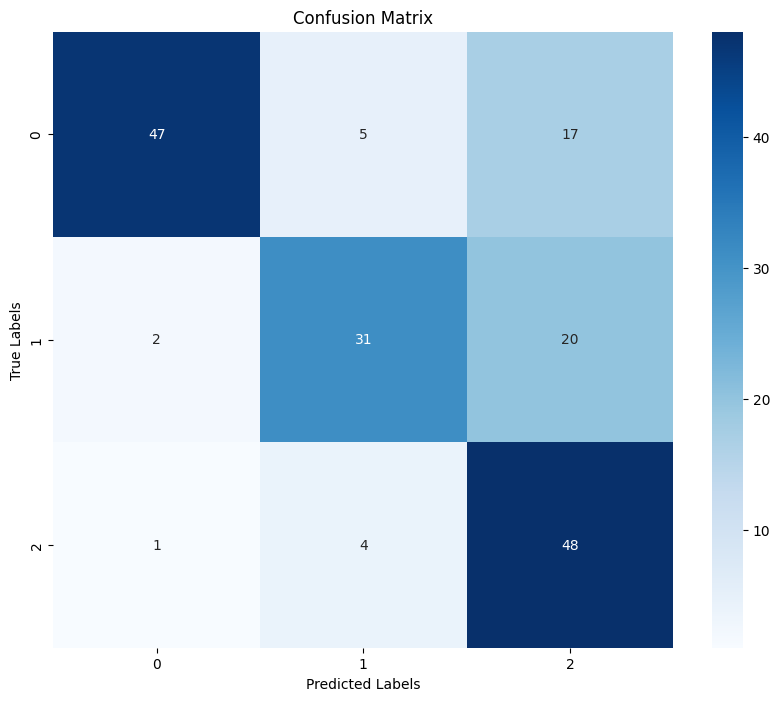

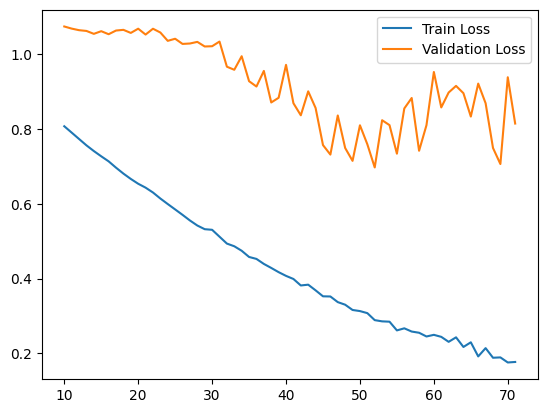

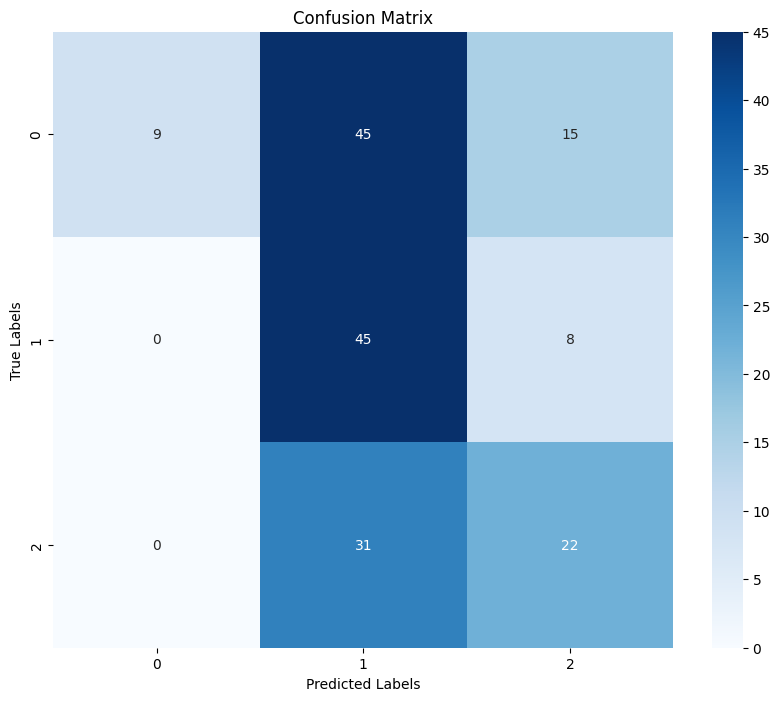

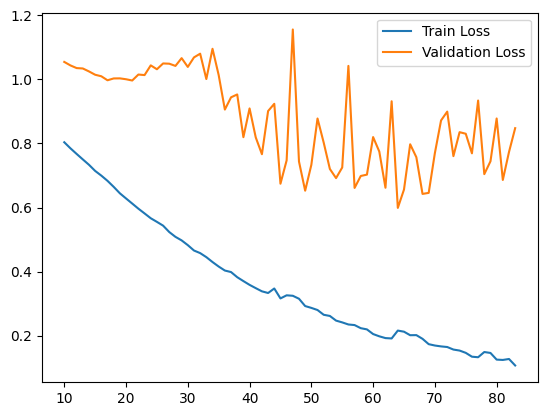

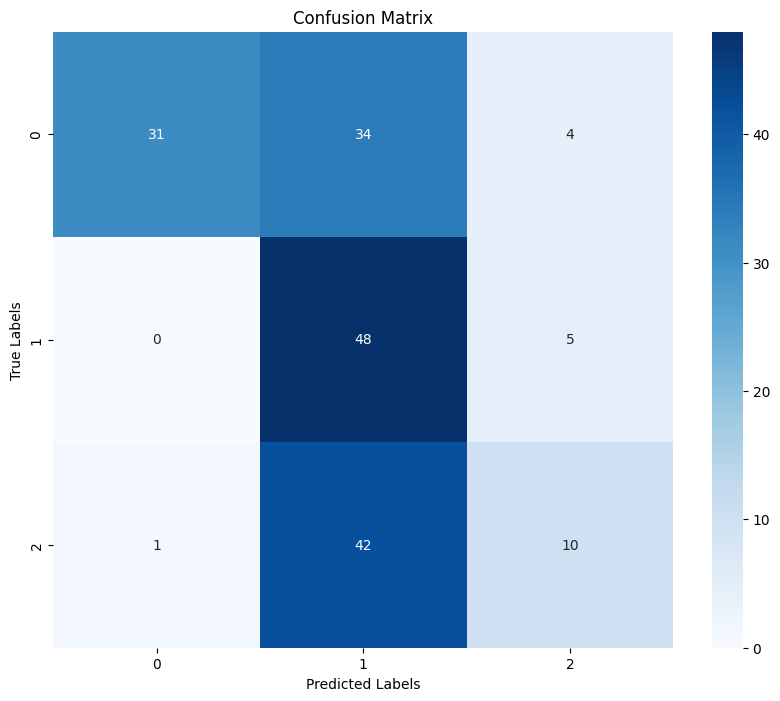

In [ ]:
results = load_results('./cls/data.json')

metrics = get_cls_metrics(results)
print('  Acurácia: ', np.round(metrics['mean_acc'],2), '+-', np.round(metrics['std_acc'],2))
print('  F1 Macro: ', np.round(metrics['mean_f1_macro'],2), '+-', np.round(metrics['std_f1_macro'],2))
print('  F1 Micro: ', np.round(metrics['mean_f1_micro'],2), '+-', np.round(metrics['std_f1_micro'],2))
print('Time (sec): ', np.round(metrics['mean_time'],2), '+-', np.round(metrics['std_time'],2))

for i in range(N_EXP):
    plot_loss_graph(results, i)
    plot_confusion_matrix(results, i)

## Regressão Extrínseca

       MSE:  0.01 +- 0.0
      RMSE:  0.07 +- 0.01
       MAE:  0.06 +- 0.02
y_true std:  0.04
Time (sec):  1.32 +- 0.42


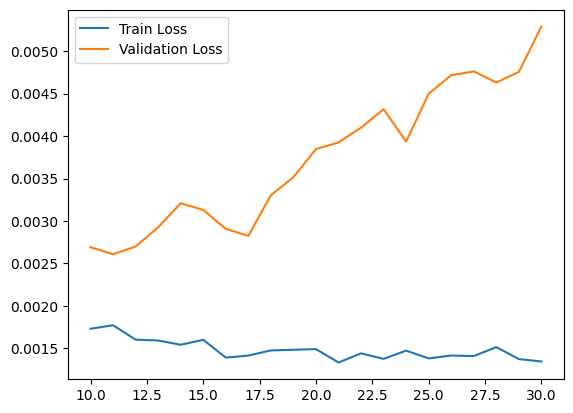

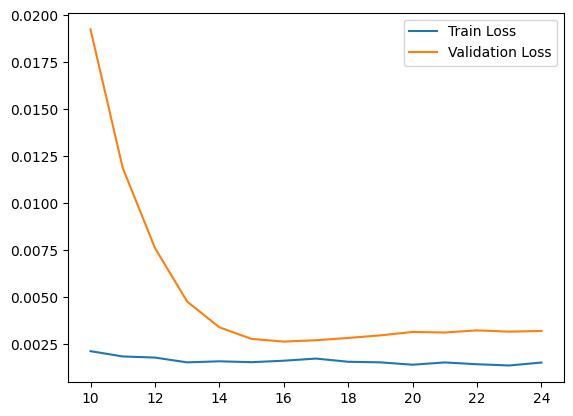

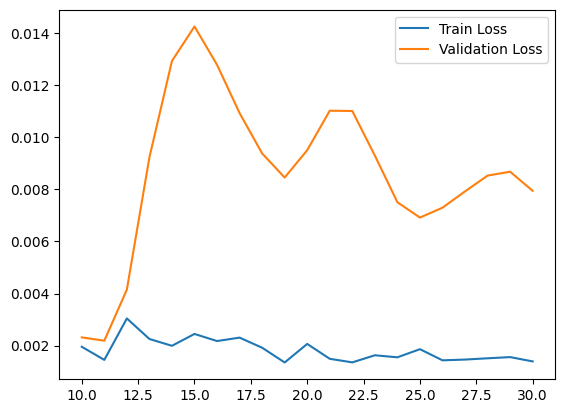

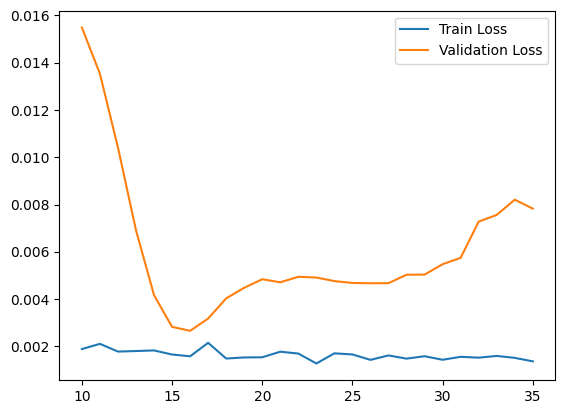

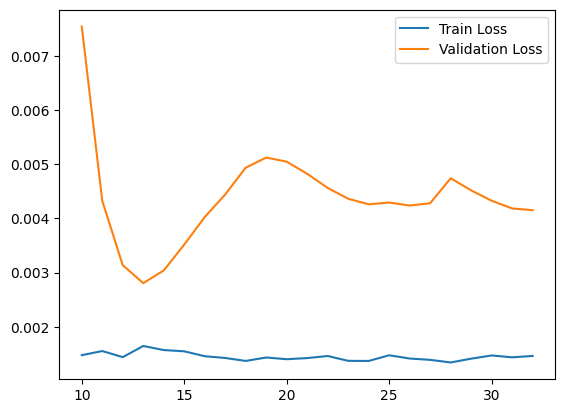

In [ ]:
X_test, y_test = load_regression(dataset_tser, split="test")

results = load_results('./tser/data.json')

metrics = get_tser_metrics(results)
print('       MSE: ', np.round(metrics['mean_mse'],2), '+-', np.round(metrics['std_mse'],2))
print('      RMSE: ', np.round(metrics['mean_rmse'],2), '+-', np.round(metrics['std_rmse'],2))
print('       MAE: ', np.round(metrics['mean_mae'],2), '+-', np.round(metrics['std_mae'],2))
print('y_true std: ', np.round(np.std(y_test),2))
print('Time (sec): ', np.round(metrics['mean_time'],2), '+-', np.round(metrics['std_time'],2))

for i in range(N_EXP):
    plot_loss_graph(results, i)